# Digit Recognizer 

by Kajal Yadav

#  Executive Summary


**Goal:** <br>

Recognize hand written digits' images (32x32 pixels in grey scale) and predict the labels which are from 0 to 9. 
It's also an ongoing competition. <br> 
Kaggle link: https://www.kaggle.com/c/digit-recognizer

**Dataset:** <br>

The dataset is obtained from the link above <br>
- Training dataset: 42,000 images, labeled 
- Test dataset: 28,000, unlabeled

Since we do not have labels for the test set we create a test set from the training set (20% of training set, technically validation set) and tabulate the results

<br>
    
**Key takeaways:** <br>

- Following are results on the test dataset 

| Model | Test Set Accuracy |
| :-: | :-: |
| Logistic Regression | 0.92 |
| Shallow Neural Network | 0.89 | 
| Fully Connected Neural Network  | 0.94 |
| Optimized Fully Connected Neural Network | 0.97 | 
| CNN architecture | 0.99|

- Logistic Regression serves as the baseline for all the models


- Neural Networks with more than 2 hidden layers performs well on this dataset. The optimized Fully Connected Neural Network Architechture has 3 Hidden layers of 128 nodes and Dropout Regularization


- Convolutional Neural Network Architechture performs exceptionally well on the dataset. The Architecture is inspired from LeNet-5 architecture. It has 2 Convolution Layers (filter size - 3x3), 2 Fully Connected layers (128, 64 nodes) and Dropout Regularization <br>




**Kaggle Submission Result:** Accuracy = 0.989 (Top 40 percentile) on unlabeled dataset


### Install Libraries

In [1]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


#  Importing libraries and data

In [3]:
import pandas as pd
import numpy as np
import keras
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Activation
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers;

In [4]:
digits_train = pd.read_csv("train.csv")
digits_test = pd.read_csv("test.csv")

# Explorarary Data Analysis

##  Structure of Data

In [5]:
digits_train.shape

(42000, 785)

Training dataset:
-  28x28 image in 784 columns and 1 label
- 42000 images

In [6]:
digits_test.shape

(28000, 784)

Test dataset:
- 28x28 image in 784 columns
- 28000 images

In [7]:
X_test = digits_test

In [8]:
X_train, y_train = digits_train.iloc[:,1:], digits_train["label"]

## Check Null values

In [9]:
digits_train.isna().sum().describe()

count    785.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

There are no null values

##  Visualize the images

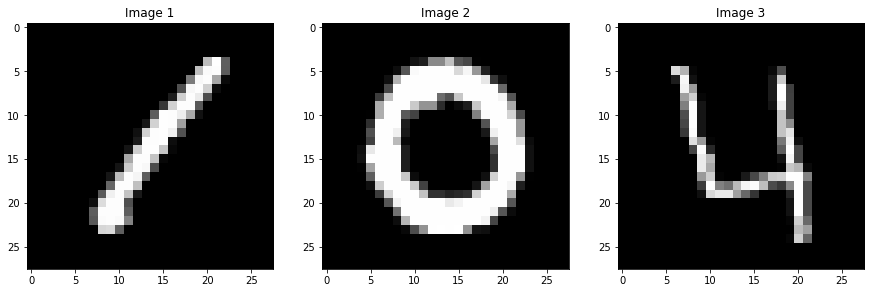

In [10]:
#Let's check how few images look like
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].set_title("Image 1")
ax[0].imshow(np.array(X_train.iloc[0]).reshape(28,28), cmap = "gray")
ax[1].set_title("Image 2")
ax[1].imshow(np.array(X_train.iloc[1]).reshape(28,28), cmap = "gray")
ax[2].set_title("Image 3")
ax[2].imshow(np.array(X_train.iloc[3]).reshape(28,28), cmap = "gray");

##  Distribution of Image labels

In [11]:
y_counts = y_train.value_counts(sort = True, normalize = True)
digits_train.groupby("label").agg({"label":"count"})

,label
label,
0,4132
1,4684
2,4177
3,4351
4,4072
5,3795
6,4137
7,4401
8,4063


In [12]:
#Mode of the distribution (Most common value)
digits_train["label"].mode()

0    1
Name: label, dtype: int64

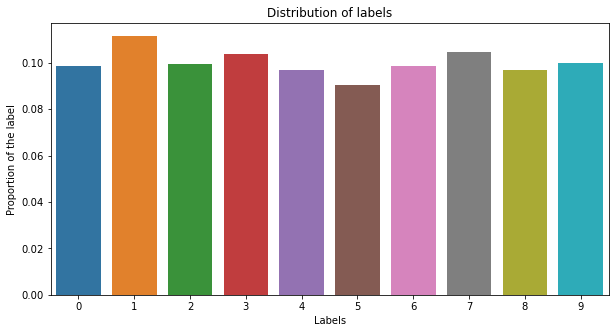

In [13]:
plt.figure(figsize = (10,5))
ax = sns.barplot(x=y_counts.index, y = y_counts.values)
ax.set_title("Distribution of labels")
ax.set_ylabel("Proportion of the label")
ax.set_xlabel("Labels");

We observe the labels are fairly evenly distributed

# Data Engineering / Wrangling

##  Normalizing
Neural networks converge faster for normalized data. The data has max 255 represeting the brightness of the image

In [14]:
X_train = X_train / 255
X_test = X_test / 255

##  Converting labels to categorical outputs

In [15]:
y_train = to_categorical(y_train, num_classes = 10)

##  Splitting the training data
- training set
- test set

We do not have labels for the test set provided on Kaggle. Hence, we test on them later with the best model

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)

## Reshaping data for use in CNN
- Length x width = 28 x 28
- Channel = 1

In [17]:
X_train_r, X_test_r = X_train.values.reshape(-1,28,28,1), X_test.values.reshape(-1,28,28,1)

# Modeling

In [18]:
Summary_table = pd.DataFrame(columns = ["model", "Test accuracy"])

## Logistic Regression
Baseline model for comparison 

In [19]:
lr = LogisticRegression(solver = "lbfgs", max_iter = 1000)

In [20]:
lr.fit(X_train, np.argmax(y_train, axis = 1));

In [21]:
test_accuracy = lr.score(X_test, np.argmax(y_test, axis = 1))

In [22]:
Summary_table  = Summary_table.append({"model": "Logistic Regression", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)

C:\Users\Kajal\AppData\Local\Temp/ipykernel_30436/1622244402.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Summary_table  = Summary_table.append({"model": "Logistic Regression", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)


In [23]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.92


## Shallow fully connected Neural Network
- Hidden layer1: 5 nodes, activation function: relu
- Optimizer: Adam
- Early stoppng: 10, stops further epochs iteration if the validation accuracy does not improve for 10 iterations

In [24]:
model_s = Sequential()
model_s.add(Dense(5, input_shape = (784,), activation = "relu"))
#Output layer
model_s.add(Dense(10, activation = "softmax"))
model_s.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [25]:
model_s.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 3925      
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


There are:
- Layer1: Weights =  784*5, Bias(each node's) = 5. Total = 3925
- Layer2 (output): Weights = 5*10 = 50, Bias (each node's) = 10. Total 60

Toatal parameters = 3985

In [26]:
early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10)

In [27]:
history = model_s.fit(X_train, y_train, epochs = 100, validation_split = 0.2, callbacks = [early_stopping]);

Epoch 1/100
840/840 [==============================] - 2s 2ms/step - loss: 1.0077 - accuracy: 0.6947 - val_loss: 0.6828 - val_accuracy: 0.7932
Epoch 2/100
840/840 [==============================] - 1s 2ms/step - loss: 0.6074 - accuracy: 0.8218 - val_loss: 0.5702 - val_accuracy: 0.8351
Epoch 3/100
840/840 [==============================] - 1s 2ms/step - loss: 0.5222 - accuracy: 0.8503 - val_loss: 0.5207 - val_accuracy: 0.8527
Epoch 4/100
840/840 [==============================] - 2s 2ms/step - loss: 0.4760 - accuracy: 0.8631 - val_loss: 0.4801 - val_accuracy: 0.8637
Epoch 5/100
840/840 [==============================] - 2s 2ms/step - loss: 0.4453 - accuracy: 0.8722 - val_loss: 0.4516 - val_accuracy: 0.8732
Epoch 6/100
840/840 [==============================] - 1s 2ms/step - loss: 0.4216 - accuracy: 0.8799 - val_loss: 0.4347 - val_accuracy: 0.8777
Epoch 7/100
840/840 [==============================] - 1s 2ms/step - loss: 0.4048 - accuracy: 0.8851 - val_loss: 0.4188 - val_accuracy: 0.8815

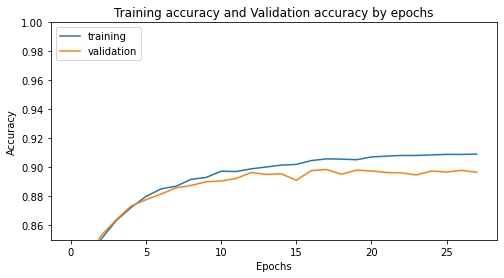

In [28]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.85,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [29]:
test_accuracy = model_s.evaluate(X_test, y_test)[1]

263/263 [==============================] - 1s 1ms/step - loss: 0.3851 - accuracy: 0.8975


In [30]:
Summary_table  = Summary_table.append({"model": "Shallow NN", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)

C:\Users\Kajal\AppData\Local\Temp/ipykernel_30436/2462669192.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Summary_table  = Summary_table.append({"model": "Shallow NN", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)


In [31]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.92
1,Shallow NN,0.897


Observation:
- Bayes error : 0 (Humans can perfectly identify)
- Training error : 0.09
- Test accuracy: 0.11

Therefore, we can focus on trying to decrease the gap between bayes error and training error with **more complex model**


## Fully Connected Neural Network (2 Hidden Layers, 5 nodes) 
- Hidden layer1: 5 nodes, activation function: relu
- Hidden layer2: 5 nodes, activation function: relu
- Optimizer: Adam
- Early stoppng: 10, stops further epochs iteration if the validation accuracy does not improve for 10 iterations
- Batch Normalization before every layer

In [32]:
model_fc = Sequential()
model_fc.add(Dense(5, input_shape = (784,), activation = "relu"))
model_fc.add(BatchNormalization())
model_fc.add(Dense(5, activation = "relu"))
model_fc.add(BatchNormalization())
model_fc.add(Dense(10, activation = "softmax"))

In [33]:
model_fc.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics =["accuracy"])

In [34]:
model_fc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 5)                 3925      
                                                                 
 batch_normalization (BatchN  (None, 5)                20        
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 5)                 30        
                                                                 
 batch_normalization_1 (Batc  (None, 5)                20        
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)                60        
                                                                 
Total params: 4,055
Trainable params: 4,035
Non-traina

In [35]:
history = model_fc.fit(X_train, y_train, validation_split = 0.2, callbacks = [early_stopping], epochs = 100);

Epoch 1/100
840/840 [==============================] - 3s 2ms/step - loss: 1.2746 - accuracy: 0.5918 - val_loss: 0.7292 - val_accuracy: 0.7909
Epoch 2/100
840/840 [==============================] - 2s 2ms/step - loss: 0.6994 - accuracy: 0.7889 - val_loss: 0.5797 - val_accuracy: 0.8317
Epoch 3/100
840/840 [==============================] - 2s 2ms/step - loss: 0.6041 - accuracy: 0.8215 - val_loss: 0.5230 - val_accuracy: 0.8443
Epoch 4/100
840/840 [==============================] - 2s 2ms/step - loss: 0.5601 - accuracy: 0.8351 - val_loss: 0.5013 - val_accuracy: 0.8482
Epoch 5/100
840/840 [==============================] - 2s 2ms/step - loss: 0.5368 - accuracy: 0.8417 - val_loss: 0.4820 - val_accuracy: 0.8579
Epoch 6/100
840/840 [==============================] - 2s 2ms/step - loss: 0.5165 - accuracy: 0.8463 - val_loss: 0.4609 - val_accuracy: 0.8632
Epoch 7/100
840/840 [==============================] - 2s 2ms/step - loss: 0.4979 - accuracy: 0.8516 - val_loss: 0.4609 - val_accuracy: 0.8606

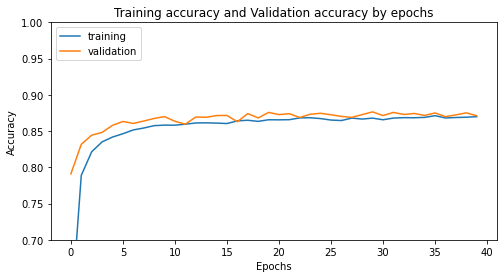

In [36]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.7,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [37]:
test_accuracy = model_fc.evaluate(X_test, y_test)[1]

263/263 [==============================] - 0s 1ms/step - loss: 0.4248 - accuracy: 0.8773


In [38]:
Summary_table  = Summary_table.append({"model": "NN 2 HL,5 nodes", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)

C:\Users\Kajal\AppData\Local\Temp/ipykernel_30436/1061659960.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Summary_table  = Summary_table.append({"model": "NN 2 HL,5 nodes", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)


Observations: <br>
Increasing  a layer has actually decrased the accuracy rather than increasing. The network needs more width (numer of nodes)

## Fully Connected Neural Network (2 Hidden Layers, 16 nodes)
- Hidden layer1: 16 nodes, activation function: relu
- Hidden layer2: 16 nodes, activation function: relu
- Optimizer: Adam
- Early stoppng: 10, stops further epochs iteration if the validation accuracy does not improve for 10 iterations
- Batch Normalization before every layer

In [39]:
model_fc16 = Sequential()
model_fc16.add(Dense(16, input_shape = (784,), activation = "relu"))
model_fc16.add(BatchNormalization())
model_fc16.add(Dense(16, activation = "relu"))
model_fc16.add(BatchNormalization())
model_fc16.add(Dense(10, activation = "softmax"))

In [40]:
model_fc16.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [41]:
model_fc16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                12560     
                                                                 
 batch_normalization_2 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_3 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 10)                170       
                                                                 
Total params: 13,130
Trainable params: 13,066
Non-trai

In [42]:
history = model_fc16.fit(X_train, y_train, validation_split = 0.2, epochs = 100, callbacks = [early_stopping])

Epoch 1/100
840/840 [==============================] - 2s 2ms/step - loss: 0.7104 - accuracy: 0.7983 - val_loss: 0.3283 - val_accuracy: 0.9039
Epoch 2/100
840/840 [==============================] - 2s 2ms/step - loss: 0.3329 - accuracy: 0.9025 - val_loss: 0.2864 - val_accuracy: 0.9168
Epoch 3/100
840/840 [==============================] - 2s 2ms/step - loss: 0.2867 - accuracy: 0.9151 - val_loss: 0.2433 - val_accuracy: 0.9296
Epoch 4/100
840/840 [==============================] - 2s 2ms/step - loss: 0.2610 - accuracy: 0.9218 - val_loss: 0.2427 - val_accuracy: 0.9312
Epoch 5/100
840/840 [==============================] - 2s 2ms/step - loss: 0.2366 - accuracy: 0.9294 - val_loss: 0.2185 - val_accuracy: 0.9366
Epoch 6/100
840/840 [==============================] - 2s 2ms/step - loss: 0.2292 - accuracy: 0.9306 - val_loss: 0.2322 - val_accuracy: 0.9307
Epoch 7/100
840/840 [==============================] - 2s 2ms/step - loss: 0.2142 - accuracy: 0.9339 - val_loss: 0.2054 - val_accuracy: 0.9406

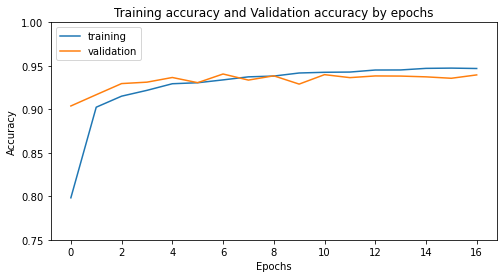

In [43]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.75,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [44]:
test_accuracy = model_fc16.evaluate(X_test, y_test)[1]

263/263 [==============================] - 1s 2ms/step - loss: 0.2017 - accuracy: 0.9417


In [45]:
Summary_table  = Summary_table.append({"model": "NN 2 HL,16 nodes", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)

C:\Users\Kajal\AppData\Local\Temp/ipykernel_30436/2742877319.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Summary_table  = Summary_table.append({"model": "NN 2 HL,16 nodes", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)


In [46]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.92
1,Shallow NN,0.897
2,"NN 2 HL,5 nodes",0.877
3,"NN 2 HL,16 nodes",0.942


Observations:
- Bayes error : 0 (Humans can perfectly identify)
- Training error : 0.04
- Test accuracy: 0.06

We have successfully reduced the bias but there still is 0.04 reducable bias which can be tackled with **more complex model**

## Optimizing Fully Connected Neural Network
Based on our observation so far, we can optimize the neural network with hyperparamters tuning:
- Optimizer: Stochastic Gradient Descent and Adam
- Nodes: 16, 32, 64, 128
- Hidden Layers: 2,3,4
- Activation function: relu, tanh

In [47]:
def create_model(optimizer ="adam", hl = 2, nodes = 16, activation = "relu"):
    model = Sequential()
    model.add(Dense(nodes, input_shape = (784,), activation = activation))
    l=1
    while(l < hl):
        model.add(Dense(nodes,activation = activation))
        model.add(BatchNormalization())
        l+=1
    model.add(Dense(10, activation = "softmax"))
    model.compile(optimizer = optimizer, loss = "categorical_crossentropy",metrics = ["accuracy"])
    return model

In [48]:
NN_parameters = {"optimizer":["sgd", "adam"], "hl":[2,3,4], "nodes":[16,32,64,128], "activation":["relu","tanh"]}

In [49]:
model = KerasClassifier(build_fn = create_model, epochs = 10)

C:\Users\Kajal\AppData\Local\Temp/ipykernel_30436/2890373991.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = create_model, epochs = 10)


In [50]:
RS_CV = RandomizedSearchCV(model, n_iter = 10, param_distributions = NN_parameters, cv = 3)

In [51]:
RS_CV.fit(X_train, y_train)

Epoch 1/10
700/700 [==============================] - 2s 2ms/step - loss: 0.5612 - accuracy: 0.8527
Epoch 2/10
700/700 [==============================] - 2s 2ms/step - loss: 0.2738 - accuracy: 0.9214
Epoch 3/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2171 - accuracy: 0.9354
Epoch 4/10
700/700 [==============================] - 1s 2ms/step - loss: 0.1838 - accuracy: 0.9437
Epoch 5/10
700/700 [==============================] - 1s 2ms/step - loss: 0.1677 - accuracy: 0.9486
Epoch 6/10
700/700 [==============================] - 1s 2ms/step - loss: 0.1504 - accuracy: 0.9546
Epoch 7/10
700/700 [==============================] - 1s 1ms/step - loss: 0.1387 - accuracy: 0.9570
Epoch 8/10
700/700 [==============================] - 1s 2ms/step - loss: 0.1322 - accuracy: 0.9586
Epoch 9/10
700/700 [==============================] - 1s 2ms/step - loss: 0.1252 - accuracy: 0.9592
Epoch 10/10
350/350 [==============================] - 0s 953us/step - loss: 0.2246 - accuracy: 0.93

350/350 [==============================] - 1s 1ms/step - loss: 0.1218 - accuracy: 0.9666
Epoch 1/10
700/700 [==============================] - 2s 2ms/step - loss: 0.5994 - accuracy: 0.8324
Epoch 2/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2801 - accuracy: 0.9192
Epoch 3/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2321 - accuracy: 0.9328
Epoch 4/10
700/700 [==============================] - 1s 2ms/step - loss: 0.2066 - accuracy: 0.9387
Epoch 5/10
700/700 [==============================] - 1s 2ms/step - loss: 0.1868 - accuracy: 0.9447
Epoch 6/10
700/700 [==============================] - 1s 2ms/step - loss: 0.1693 - accuracy: 0.9487
Epoch 7/10
700/700 [==============================] - 1s 2ms/step - loss: 0.1619 - accuracy: 0.9506
Epoch 8/10
700/700 [==============================] - 1s 2ms/step - loss: 0.1539 - accuracy: 0.9517
Epoch 9/10
700/700 [==============================] - 1s 2ms/step - loss: 0.1424 - accuracy: 0.9557
Epoch 10/10

350/350 [==============================] - 1s 3ms/step - loss: 0.1230 - accuracy: 0.9662
Epoch 1/10
1050/1050 [==============================] - 4s 3ms/step - loss: 0.2763 - accuracy: 0.9177
Epoch 2/10
1050/1050 [==============================] - 3s 3ms/step - loss: 0.1223 - accuracy: 0.9628
Epoch 3/10
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0900 - accuracy: 0.9721
Epoch 4/10
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0693 - accuracy: 0.9777
Epoch 5/10
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0590 - accuracy: 0.9812
Epoch 6/10
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0497 - accuracy: 0.9835
Epoch 7/10
1050/1050 [==============================] - 5s 4ms/step - loss: 0.0423 - accuracy: 0.9864
Epoch 8/10
1050/1050 [==============================] - 5s 4ms/step - loss: 0.0334 - accuracy: 0.9895
Epoch 9/10
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0300 - accuracy: 

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001429C8DB580>,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'hl': [2, 3, 4],
                                        'nodes': [16, 32, 64, 128],
                                        'optimizer': ['sgd', 'adam']})

In [52]:
RS_CV.best_params_

{'optimizer': 'adam', 'nodes': 128, 'hl': 2, 'activation': 'relu'}

Best parameters:
- Optimizer: Adaptive Moment Estimation
- 2 hidden layers
- Activation relu

In [53]:
model_fc_o = create_model(optimizer= "sgd", nodes = 128, hl = 3, activation = "relu")

In [54]:
history = model_fc_o.fit(X_train, y_train, validation_split = 0.2, epochs = 100, callbacks = [early_stopping])

Epoch 1/100
840/840 [==============================] - 3s 3ms/step - loss: 0.4514 - accuracy: 0.8642 - val_loss: 0.2413 - val_accuracy: 0.9290
Epoch 2/100
840/840 [==============================] - 3s 4ms/step - loss: 0.2238 - accuracy: 0.9346 - val_loss: 0.1941 - val_accuracy: 0.9439
Epoch 3/100
840/840 [==============================] - 4s 5ms/step - loss: 0.1656 - accuracy: 0.9517 - val_loss: 0.1530 - val_accuracy: 0.9548
Epoch 4/100
840/840 [==============================] - 4s 5ms/step - loss: 0.1346 - accuracy: 0.9604 - val_loss: 0.1354 - val_accuracy: 0.9580
Epoch 5/100
840/840 [==============================] - 4s 5ms/step - loss: 0.1141 - accuracy: 0.9666 - val_loss: 0.1328 - val_accuracy: 0.9598
Epoch 6/100
840/840 [==============================] - 3s 4ms/step - loss: 0.0977 - accuracy: 0.9714 - val_loss: 0.1244 - val_accuracy: 0.9621
Epoch 7/100
840/840 [==============================] - 5s 5ms/step - loss: 0.0830 - accuracy: 0.9766 - val_loss: 0.1095 - val_accuracy: 0.9655

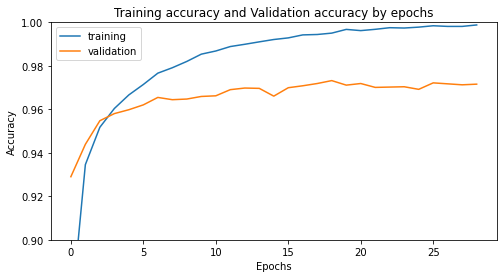

In [55]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.9,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [56]:
test_accuracy = model_fc_o.evaluate(X_test, y_test)[1]

263/263 [==============================] - 2s 4ms/step - loss: 0.1231 - accuracy: 0.9682


In [57]:
Summary_table  = Summary_table.append({"model": "Opimized NN (3 HL, 128 nodes)", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)

C:\Users\Kajal\AppData\Local\Temp/ipykernel_30436/138887270.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Summary_table  = Summary_table.append({"model": "Opimized NN (3 HL, 128 nodes)", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)


In [58]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.92
1,Shallow NN,0.897
2,"NN 2 HL,5 nodes",0.877
3,"NN 2 HL,16 nodes",0.942
4,"Opimized NN (3 HL, 128 nodes)",0.968


Observations:
- Bayes error : 0 (Humans can perfectly identify)
- Training error : 0.002
- Test error: 0.030

We have successfully reduced the bias but there is varaince now due to **overfitting**.Variance can be decreased by:
- Drop out regularization
- l2 Regularization 

## Dropout Regularization 

In [59]:
model_fc_r = Sequential()
model_fc_r.add(Dense(128, input_shape = (784,), activation = "relu"))
model_fc_r.add(BatchNormalization())
model_fc_r.add(Dropout(0.2))
model_fc_r.add(Dense(128, activation = "relu"))
model_fc_r.add(BatchNormalization())
model_fc_r.add(Dropout(0.2))
model_fc_r.add(Dense(128, activation = "relu"))
model_fc_r.add(BatchNormalization())
model_fc_r.add(Dropout(0.2))
model_fc_r.add(Dense(10, activation = "softmax"))

In [60]:
model_fc_r.compile(optimizer = "sgd", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [61]:
history = model_fc_r.fit(X_train, y_train, validation_split = 0.2, epochs = 100, callbacks = [early_stopping])

Epoch 1/100
840/840 [==============================] - 8s 6ms/step - loss: 0.7021 - accuracy: 0.7803 - val_loss: 0.2706 - val_accuracy: 0.9187
Epoch 2/100
840/840 [==============================] - 4s 5ms/step - loss: 0.3772 - accuracy: 0.8850 - val_loss: 0.2061 - val_accuracy: 0.9366
Epoch 3/100
840/840 [==============================] - 4s 5ms/step - loss: 0.3168 - accuracy: 0.9037 - val_loss: 0.1727 - val_accuracy: 0.9467
Epoch 4/100
840/840 [==============================] - 3s 4ms/step - loss: 0.2695 - accuracy: 0.9186 - val_loss: 0.1559 - val_accuracy: 0.9519
Epoch 5/100
840/840 [==============================] - 3s 4ms/step - loss: 0.2344 - accuracy: 0.9278 - val_loss: 0.1385 - val_accuracy: 0.9582
Epoch 6/100
840/840 [==============================] - 4s 5ms/step - loss: 0.2204 - accuracy: 0.9328 - val_loss: 0.1290 - val_accuracy: 0.9609
Epoch 7/100
840/840 [==============================] - 4s 4ms/step - loss: 0.2017 - accuracy: 0.9377 - val_loss: 0.1227 - val_accuracy: 0.9619

Epoch 58/100
840/840 [==============================] - 4s 5ms/step - loss: 0.0564 - accuracy: 0.9812 - val_loss: 0.0768 - val_accuracy: 0.9786
Epoch 59/100
840/840 [==============================] - 5s 5ms/step - loss: 0.0542 - accuracy: 0.9827 - val_loss: 0.0795 - val_accuracy: 0.9780
Epoch 60/100
840/840 [==============================] - 4s 4ms/step - loss: 0.0550 - accuracy: 0.9821 - val_loss: 0.0788 - val_accuracy: 0.9787
Epoch 61/100
840/840 [==============================] - 4s 4ms/step - loss: 0.0526 - accuracy: 0.9830 - val_loss: 0.0767 - val_accuracy: 0.9778
Epoch 62/100
840/840 [==============================] - 4s 4ms/step - loss: 0.0480 - accuracy: 0.9840 - val_loss: 0.0781 - val_accuracy: 0.9778
Epoch 63/100
840/840 [==============================] - 3s 4ms/step - loss: 0.0499 - accuracy: 0.9830 - val_loss: 0.0813 - val_accuracy: 0.9780
Epoch 64/100
840/840 [==============================] - 5s 5ms/step - loss: 0.0501 - accuracy: 0.9829 - val_loss: 0.0796 - val_accuracy:

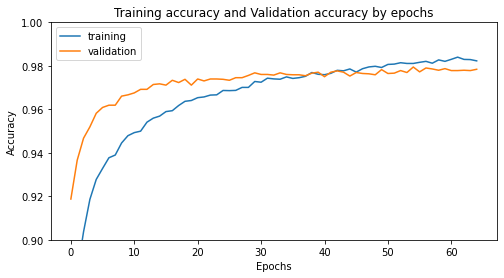

In [62]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.9,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [63]:
test_accuracy = model_fc_r.evaluate(X_test, y_test)[1]

263/263 [==============================] - 1s 3ms/step - loss: 0.0990 - accuracy: 0.9746


In [64]:
Summary_table  = Summary_table.append({"model": "Opimized NN (3 HL, 128 nodes) with Dropout", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)

C:\Users\Kajal\AppData\Local\Temp/ipykernel_30436/3536854214.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Summary_table  = Summary_table.append({"model": "Opimized NN (3 HL, 128 nodes) with Dropout", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)


In [65]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.92
1,Shallow NN,0.897
2,"NN 2 HL,5 nodes",0.877
3,"NN 2 HL,16 nodes",0.942
4,"Opimized NN (3 HL, 128 nodes)",0.968
5,"Opimized NN (3 HL, 128 nodes) with Dropout",0.975


Observation: <br>

 We reduced the variance using regularization and the model generalizes beeter 

## Convolutional Neural Network 
CNNs are great for image detection for following reasons: 
- **Lesser number of parameters to train**: CNNs filters involve paramter sharing across the image
- **Sparsity of connections**: Each output is connected to a only a few inputs in CNNs, unlike fully connected layer where every input is connected to the output
- **Roboust to translation in variance**: CNNs are robust to translation in variance of the image. This generally happens when the image is roatated, shifted, cropped however the image label is same hence this proprety is desirable in image recognition 

Trying a model similar to the LeNet-5 architechture
- Layer1: CONV layer filter size 3x3, stride 1, Maxpooling layer 2x2, Batch Normalizaton
- Layer2: CONV layer filter size 3x3, stride 1, Maxpooling layer 2x2, Batch Normalizaton
- Layer3: Fully connected layer 128 nodes with Dropout
- Layer4: Fully connected layer 64 nodes with Dropout

In [66]:
model_cnn1 = Sequential()
#Layer1
model_cnn1.add(Conv2D(filters = 8, kernel_size = (3,3), input_shape = (28,28,1), name= "conv0"))
model_cnn1.add(BatchNormalization(name = "bn0"))
model_cnn1.add(Activation("relu", name = "ac0"))
model_cnn1.add(MaxPooling2D(pool_size = (2,2), name = "mp0"))
#Layer2
model_cnn1.add(Conv2D(filters = 16, kernel_size = (3,3), name = "conv1"))
model_cnn1.add(BatchNormalization(name = "bn1"))
model_cnn1.add(Activation("relu", name="ac1"))
model_cnn1.add(MaxPooling2D(pool_size = (2,2), name = "mp1"))
#Flatten Outputs
model_cnn1.add(Flatten())
#Layer3
model_cnn1.add(Dense(128, name = "fc0"))
model_cnn1.add(BatchNormalization(name = "bn2"))
model_cnn1.add(Activation("relu", name = "ac2"))
model_cnn1.add(Dropout(0.2))
#Layer4
model_cnn1.add(Dense(64, name = "fc1"))
model_cnn1.add(BatchNormalization(name = "bn3"))
model_cnn1.add(Activation("relu", name = "ac3"))
model_cnn1.add(Dropout(0.2))
#Output
model_cnn1.add(Dense(10, name = "output", activation = "softmax"))

In [67]:
model_cnn1.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv0 (Conv2D)              (None, 26, 26, 8)         80        
                                                                 
 bn0 (BatchNormalization)    (None, 26, 26, 8)         32        
                                                                 
 ac0 (Activation)            (None, 26, 26, 8)         0         
                                                                 
 mp0 (MaxPooling2D)          (None, 13, 13, 8)         0         
                                                                 
 conv1 (Conv2D)              (None, 11, 11, 16)        1168      
                                                                 
 bn1 (BatchNormalization)    (None, 11, 11, 16)        64        
                                                                 
 ac1 (Activation)            (None, 11, 11, 16)      

In [68]:
model_cnn1.compile(optimizer = "adam", loss = "categorical_crossentropy",  metrics = ["accuracy"])

In [69]:
history = model_cnn1.fit(X_train_r, y_train, validation_split = 0.2, epochs = 100, callbacks = [early_stopping])

Epoch 1/100
840/840 [==============================] - 15s 17ms/step - loss: 0.3398 - accuracy: 0.9076 - val_loss: 0.0756 - val_accuracy: 0.9786
Epoch 2/100
840/840 [==============================] - 15s 17ms/step - loss: 0.1172 - accuracy: 0.9660 - val_loss: 0.0496 - val_accuracy: 0.9841
Epoch 3/100
840/840 [==============================] - 15s 18ms/step - loss: 0.0887 - accuracy: 0.9736 - val_loss: 0.0553 - val_accuracy: 0.9827
Epoch 4/100
840/840 [==============================] - 14s 16ms/step - loss: 0.0759 - accuracy: 0.9765 - val_loss: 0.0488 - val_accuracy: 0.9838
Epoch 5/100
840/840 [==============================] - 14s 16ms/step - loss: 0.0611 - accuracy: 0.9818 - val_loss: 0.0476 - val_accuracy: 0.9853
Epoch 6/100
840/840 [==============================] - 16s 19ms/step - loss: 0.0545 - accuracy: 0.9836 - val_loss: 0.0368 - val_accuracy: 0.9888
Epoch 7/100
840/840 [==============================] - 16s 19ms/step - loss: 0.0496 - accuracy: 0.9845 - val_loss: 0.0402 - val_ac

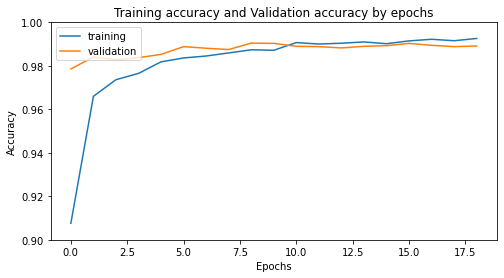

In [70]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.9,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [71]:
test_accuracy = model_cnn1.evaluate(X_test_r, y_test)[1]

263/263 [==============================] - 2s 7ms/step - loss: 0.0422 - accuracy: 0.9876


In [72]:
Summary_table  = Summary_table.append({"model": "CNN architecture", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)

C:\Users\Kajal\AppData\Local\Temp/ipykernel_30436/3015373111.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Summary_table  = Summary_table.append({"model": "CNN architecture", "Test accuracy": np.round(test_accuracy,3) }, ignore_index = True)


In [73]:
Summary_table 

,model,Test accuracy
0,Logistic Regression,0.92
1,Shallow NN,0.897
2,"NN 2 HL,5 nodes",0.877
3,"NN 2 HL,16 nodes",0.942
4,"Opimized NN (3 HL, 128 nodes)",0.968
5,"Opimized NN (3 HL, 128 nodes) with Dropout",0.975
6,CNN architecture,0.988


# Submission on Test Data

Training the network on the whole data to submit prediction

In [74]:
X_train, y_train = digits_train.iloc[:,1:], digits_train["label"]
X_train = X_train / 255
X_test = digits_test
X_test = X_test / 255

In [75]:
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)
X_train_r, X_test_r = X_train.values.reshape(-1,28,28,1), X_test.values.reshape(-1,28,28,1)

In [76]:
X_train_r.shape

(42000, 28, 28, 1)

In [77]:
X_test_r.shape

(28000, 28, 28, 1)

In [78]:
model_cnn1.fit(X_train_r, y_train, epochs = 100, validation_split= 0.1, callbacks = [early_stopping])

Epoch 1/100
1182/1182 [==============================] - 25s 20ms/step - loss: 0.0388 - accuracy: 0.9881 - val_loss: 0.0114 - val_accuracy: 0.9974
Epoch 2/100
1182/1182 [==============================] - 23s 19ms/step - loss: 0.0307 - accuracy: 0.9906 - val_loss: 0.0138 - val_accuracy: 0.9957
Epoch 3/100
1182/1182 [==============================] - 22s 18ms/step - loss: 0.0266 - accuracy: 0.9915 - val_loss: 0.0114 - val_accuracy: 0.9957
Epoch 4/100
1182/1182 [==============================] - 23s 20ms/step - loss: 0.0269 - accuracy: 0.9917 - val_loss: 0.0145 - val_accuracy: 0.9957
Epoch 5/100
1182/1182 [==============================] - 22s 18ms/step - loss: 0.0227 - accuracy: 0.9924 - val_loss: 0.0155 - val_accuracy: 0.9943
Epoch 6/100
1182/1182 [==============================] - 24s 20ms/step - loss: 0.0242 - accuracy: 0.9922 - val_loss: 0.0133 - val_accuracy: 0.9962
Epoch 7/100
1182/1182 [==============================] - 22s 19ms/step - loss: 0.0217 - accuracy: 0.9928 - val_loss: 0

In [79]:
predictions = model_cnn1.predict(X_test_r)
predictions = np.argmax(predictions, axis = 1)

In [80]:
submission = pd.DataFrame({"ImageId":np.arange(len(predictions))+1, "Label":predictions}) 

In [81]:
submission.to_csv("submission.csv", index = False)

# Future steps
- Further optimization of hyperparameters of CNN
- Larger architechtures
- Try other regularization techniques like l2
- Implementation of ResNets
- Data Augmentation 
- Ensemble of different architectures and combining results

# Credits 
- Andrew NG (Coursera Deep Learning Specialization)
- Ethan Swan (Lead Data Scientist at 84.51)
- LeNet-5 (http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) 
- François Chollet